
# Recommendation System:

This notebook will segment customers into distinct clusters using KMeans. For each cluster, the most frequently purchased product will be identified and recommended to cluster members who haven't yet purchased it. This approach leverages collective purchase patterns to provide targeted product recommendations, enhancing sales and marketing effectiveness.

> Reference:
> - Chen, D. Sain, S.L., and Guo, K. (2012), Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208. https://doi.org/10.1057/dbm.2012.17
>   - Original Dataset source: https://archive.ics.uci.edu/dataset/502/online+retail+ii
>   - Original Dataset DOI: https://doi.org/10.24432/C5CG6D
>   - License: This dataset is licensed under a [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode) (CC BY 4.0) license.
>   - Uploaded DataSet to Kaggle used in this notebook: - https://www.kaggle.com/datasets/samantas2020/online-retail-xls
>   - This notebook is adapted from Samira Qasemi's original notebook on the Kaggle [site](https://www.kaggle.com/code/samantas2020/online-retail-clustering-recommendation-system).

## Step 1 | Importing The Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Step 2 | Loading and Reading the Dataset

In [2]:
df = pd.read_excel('files/online_retail_II.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Exploring Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df = df[df['CustomerID'].notnull()]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


## Step 3 | Add Features:

### Filter out suppliers from the dataset:
- The dataset contains sales (to customers) and purchases (from suppliers); indicated by a negative Quantity column. So we will start by removing suppliers, to only focus on customers.

In [6]:
df = df[(df['Quantity']>=0)]

### Creating 'InvoiceDay' Column for Date-Based Analysis"


Parse the date only, from the InvoiceDate (with timestamp) column. This helps us later when we will define categories against which to group customers.


In [7]:
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


### Creating 'TotalSum' Variable for Financial Analysis

Create a new variable called 'TotalSum' -  the total cost of a record `= quantity x unit price`.

* We can calculate the total cost of purchases for each customer.

Useful for financial analysis, generating aggregate reports, and data-driven decision-making.

In [9]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


### Creating RFM Variables for Customer Analysis and Marketing Strategies: 


Create RFM (Recency, Frequency, Monetary) variables for each customer. These three variables hold domain significance in customer analysis and marketing strategies:

1. `Recency (R): Number of days since the last purchase.` - To assess how active customers are and whether they require further engagement or not.
2. `Frequency (F): Total number of purchases by customer.` - To identify customers with frequent purchases, enabling us to provide them with special discounts and offers.
3. `Monetary (M): Total money spent by customer on purchases.` - To identify customers with higher spending and designating them as valuable, high-potential customers.

These will allow classification of customers based on these factors for more effective customer-centric approaches.

* First define today's date / latest date in the dataset. (`dt.timedelta(1)` defines 1 day, so 1 + max days).

In [10]:
pin_date = max(df['InvoiceDay']) + dt.timedelta(1)
pin_date

Timestamp('2011-12-10 00:00:00')

* Next, create a new data table, containing the RFM data per CustomerID:
    * Groupby let's us perform aggregate functions over the product purchases dataframe; to produce a new table.

In [11]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDay': lambda x: (pin_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})
rfm

,InvoiceDay,InvoiceNo,TotalSum
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [12]:
rfm.rename(columns= {
    'InvoiceDay': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


## Step 4 | Create Equal Grouping Labels for each of RFM, as Low-Medium-High:

Perform domain-specific data preprocessing. 

1. Using the calculated variables `Recency, Frequency, and Monetary` from the original data (See [Chen, 2012] for reference). 
2. Transform these variables into equally-grouped categories.
3. Define group-label choices for each variable.

RFM Variables:
- `Recency` is transformed into four categories, where each category represents a specific time interval from the last purchase made by the customer (with labels from 4 to 1, where 4 indicates closer proximity to the last purchase and 1 indicates a longer time span since the last purchase).
- `Frequency` is also categorized into four groups, with each group indicating the total number of purchases made by the customer within a specified range (with labels from 1 to 4, where 1 represents the lowest number of purchases and 4 represents the highest).
- `Monetary` is divided into four categories, with each cluster representing the amount of money spent by the customer on their purchases (with labels from 1 to 4, where 1 indicates the lowest monetary value and 4 indicates the highest).

This categorization into groups helps classify customers based on their performance in these three critical metrics (Recency, Frequency, Monetary). It enables us to implement marketing and customer-centric strategies more effectively.


In [13]:
r_labels = range(3, 0, -1) #[3, 2, 1]
r_groups = pd.qcut(rfm['Recency'], q=3, labels=r_labels)
f_labels = range(1, 4) # [1, 2, 3]
f_groups = pd.qcut(rfm['Frequency'], q=3, labels=f_labels)
m_labels = range(1, 4)
m_groups = pd.qcut(rfm['Monetary'], q=3, labels=m_labels)

In [14]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values
rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,3
12347.0,3,182,4310.00,3,3,3
12348.0,76,31,1797.24,2,2,3
12349.0,19,73,1757.55,3,2,3
12350.0,311,17,334.40,1,1,1
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,3,1,1


## Step 5 | Customer Clustering for Targeted Marketing


Segment customers into clusters using the K-Means clustering algorithm. 
- This allows us to categorize customers based on their behavior regarding recency, frequency, and monetary value.
- By grouping customers into clusters, we can implement different marketing and customer-centric strategies for each group, leading to more effective and personalized approaches.

In [17]:
X = rfm[['R', 'F', 'M']]

- Scale the selected data (`X` only) for modelling, encode and handle missing values.

In [16]:
def one_hot_encode(df, columns_to_encode):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in columns_to_encode:
        if col in df_encoded.columns: #Check if the column exists.
            one_hot = pd.get_dummies(df_encoded[col], prefix=col)
            df_encoded = pd.concat([df_encoded, one_hot], axis=1)
            df_encoded = df_encoded.drop(col, axis=1) #remove the original column
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df_encoded

In [18]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Evaluate a few cluster sizes `n_clusters` and select the best using the "Elbow Method":

In [19]:
def _plot_wcss_elbow_method(n_clusters_range, wcss):
    plt.plot(n_clusters_range, wcss, marker='o')
    plt.title('Elbow Method:')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(n_clusters_range)
    plt.grid(True)
    plt.show()

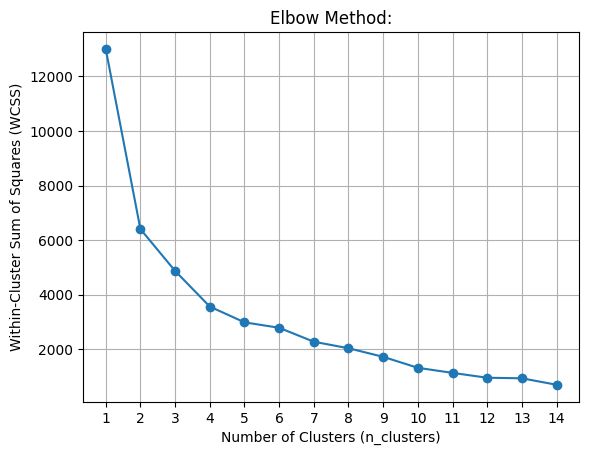

In [27]:
from sklearn.cluster import KMeans

n_clusters_range = range(1,15)
wcss = []
for n_clusters in n_clusters_range:
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=20000)
    model.fit(X_scaled)
    wcss.append(model.inertia_)  # inertia_ is the WCSS
    
_plot_wcss_elbow_method(n_clusters_range, wcss)

- Choose the best `n_clusters` value using the "Elbow Method", and enter below as `num_clusters`.

In [28]:
# Number of clusters
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300)
kmeans.fit(X_scaled)

KMeans(n_clusters=6)

In [29]:
kmeans.labels_

array([3, 4, 5, ..., 0, 4, 5])

In [30]:
rfm['kmeans_cluster'] = kmeans.labels_

In [31]:
rfm

,Recency,Frequency,Monetary,R,F,M,kmeans_cluster
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,3,3
12347.0,3,182,4310.00,3,3,3,4
12348.0,76,31,1797.24,2,2,3,5
12349.0,19,73,1757.55,3,2,3,4
12350.0,311,17,334.40,1,1,1,2
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,2
18281.0,181,7,80.82,1,1,1,2
18282.0,8,12,178.05,3,1,1,0


## Step 6 | Customer Clustering Visualization

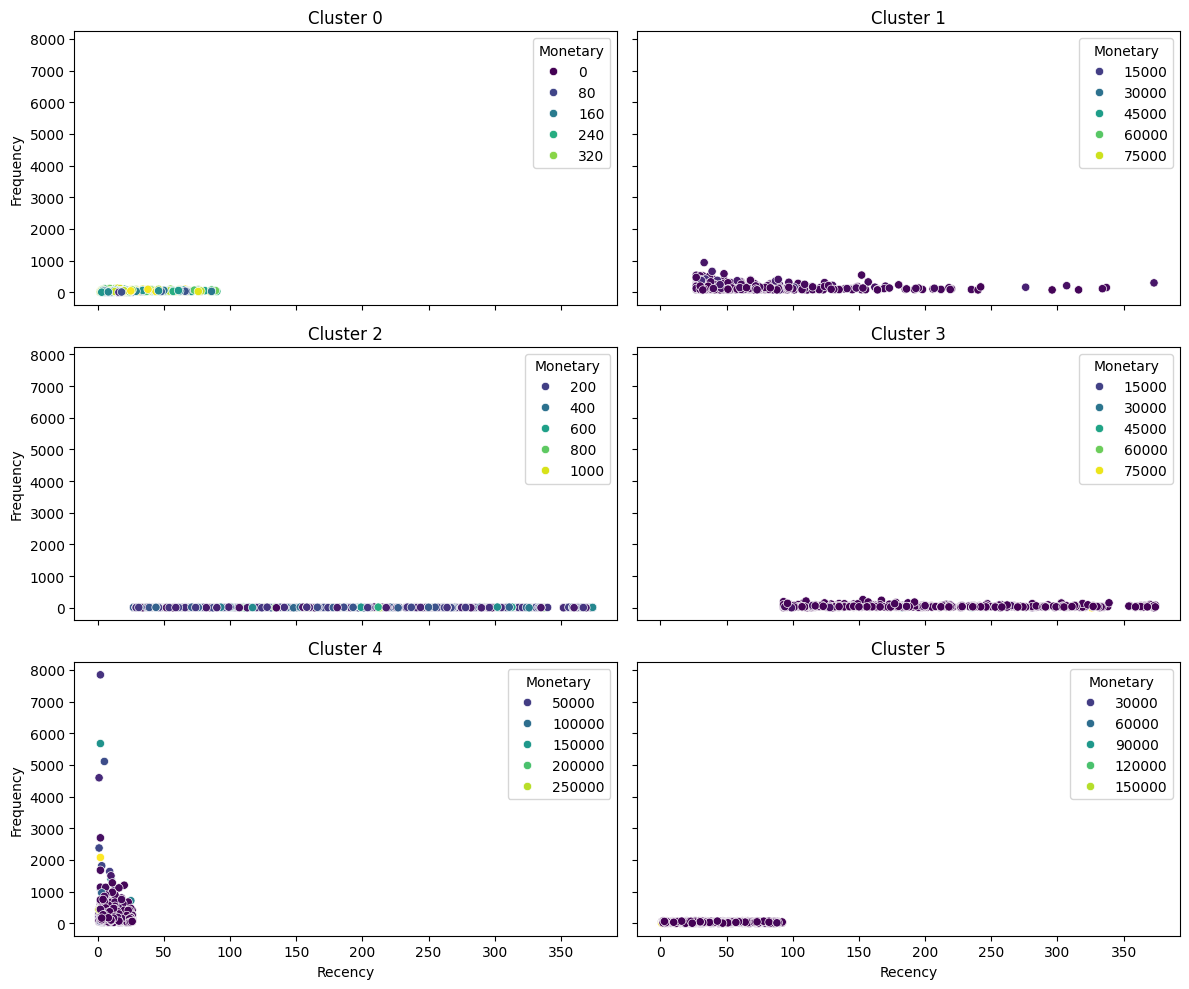

In [32]:


# Create subplots with two clusters in each row
fig, axes = plt.subplots(num_clusters // 2, 2, figsize=(12, 10), sharey=True, sharex=True)
# Flatten the axes array to iterate through subplots
axes = axes.ravel()

# Loop through each cluster and plot it
for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = rfm[rfm['kmeans_cluster'] == cluster_id]
    sns.scatterplot(data=cluster_data, x='Recency', y='Frequency', hue='Monetary', palette='viridis', ax=axes[cluster_id])
    axes[cluster_id].set_title(f'Cluster {cluster_id}')
    axes[cluster_id].set_xlabel('Recency')

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()


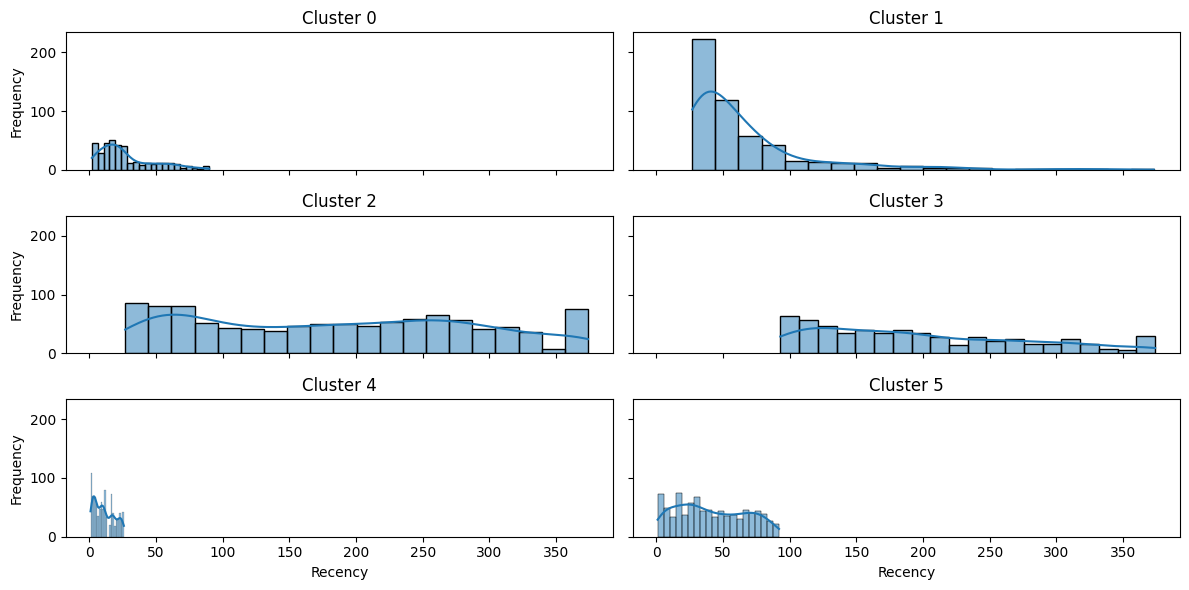

In [33]:
# Create a histogram for Recency in each cluster

fig, axes = plt.subplots(num_clusters // 2, 2, figsize=(12, 6), sharey=True, sharex=True)
# Flatten the axes array to iterate through subplots
axes = axes.ravel()

for cluster_id in range(num_clusters):
    # plt.subplot(2, 5, cluster_id + 1)
    sns.histplot(rfm[rfm['kmeans_cluster'] == cluster_id]['Recency'], bins=20, kde=True, ax=axes[cluster_id])
    plt.title(f'Cluster {cluster_id}')
    axes[cluster_id].set_title(f'Cluster {cluster_id}')
    axes[cluster_id].set_xlabel('Recency')
    axes[cluster_id].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()


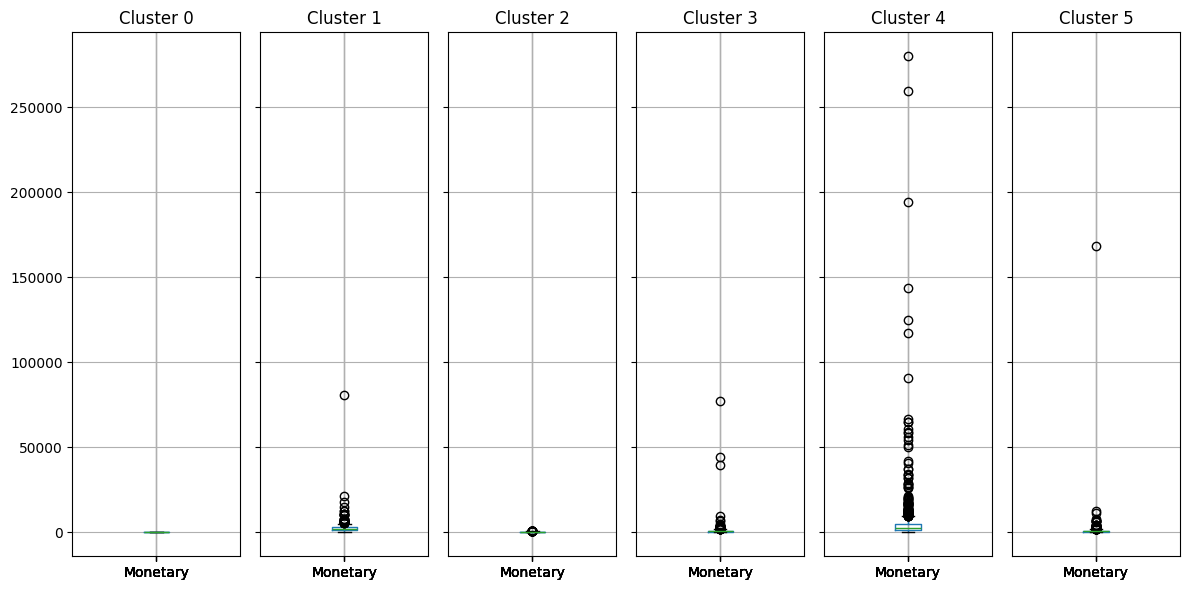

In [34]:
# Create a histogram for Recency in each cluster

fig, axes = plt.subplots(1, num_clusters, figsize=(12, 6), sharey=True, sharex=True)
# Flatten the axes array to iterate through subplots
axes = axes.ravel()

for cluster_id in range(num_clusters):
    rfm[rfm['kmeans_cluster'] == cluster_id][['Monetary']].boxplot(ax=axes[cluster_id])
    plt.title(f'Cluster {cluster_id}')
    axes[cluster_id].set_title(f'Cluster {cluster_id}')
    
plt.tight_layout()
plt.show()


- By viewing the Monetary clusters as boxplots, some cluster(s) will illustrate higher purchasing clients more clearly.
- This can help guide the selection of target cluster group, for recommendations and interventions.

### View all Customers from a Cluster:

In [35]:
rfm[rfm['kmeans_cluster'] == 1]

,Recency,Frequency,Monetary,R,F,M,kmeans_cluster
CustomerID,,,,,,,
12352.0,37,85,2506.04,2,3,3,1
12357.0,34,131,6207.67,2,3,3,1
12359.0,58,248,6372.58,2,3,3,1
12360.0,53,129,2662.06,2,3,3,1
12370.0,52,167,3545.69,2,3,3,1
...,...,...,...,...,...,...,...
18239.0,219,88,1561.61,1,3,3,1
18242.0,73,78,2232.49,2,3,3,1
18252.0,51,98,526.67,2,3,2,1


## Step 7 | Creating a Recommendation System

### Generating Top Product Recommendations for Each Cluster 

In [36]:
# Create an empty dictionary to store recommendations for each cluster
cluster_recommendations = {}
number_of_most_sold_products = 5

# Loop through each cluster
for cluster_id in range(num_clusters):
    # Find customers in the current cluster
    customers_in_cluster = rfm[rfm['kmeans_cluster'] == cluster_id].index
    
    # Find top products for customers in the current cluster
    top_products_for_cluster = df[	df['CustomerID'].isin(customers_in_cluster) ].groupby(
                                        ['StockCode'])['InvoiceNo'].count().sort_values(
                                                    ascending=False).head(
                                                                number_of_most_sold_products
                                                    )
    
    # Add top products for the current cluster in the dictionary
    cluster_recommendations[f'Cluster {cluster_id}'] = {'StockCode':top_products_for_cluster.index.tolist(),
                                                        'Qty':top_products_for_cluster.values.tolist()}

# Display the recommendations for each cluster
for cluster, recommended_products in cluster_recommendations.items():
    print(f"{cluster} -> Most Sold Products: {recommended_products}")
    dfr = df[df['StockCode'].isin(
        recommended_products['StockCode'])][['StockCode','Description']].drop_duplicates(subset='StockCode').copy()
    dfr['SoldQtyInCluster'] = recommended_products['Qty']
    display(dfr)


Cluster 0 -> Most Sold Products: {'StockCode': [21034, '85123A', 23084, 22086, 22578], 'Qty': [85, 52, 42, 42, 41]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,85
46,22086,PAPER CHAIN KIT 50'S CHRISTMAS,52
591,21034,REX CASH+CARRY JUMBO SHOPPER,42
2281,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN,42
183218,23084,RABBIT NIGHT LIGHT,41


Cluster 1 -> Most Sold Products: {'StockCode': ['85123A', 22423, 47566, '85099B', 20725], 'Qty': [440, 372, 322, 310, 295]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,440
93,20725,LUNCH BAG RED RETROSPOT,372
177,85099B,JUMBO BAG RED RETROSPOT,322
880,22423,REGENCY CAKESTAND 3 TIER,310
6572,47566,PARTY BUNTING,295


Cluster 2 -> Most Sold Products: {'StockCode': ['85123A', 22423, 47566, 'POST', 84946], 'Qty': [110, 110, 80, 66, 58]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,110
45,POST,POSTAGE,110
880,22423,REGENCY CAKESTAND 3 TIER,80
4073,84946,ANTIQUE SILVER TEA GLASS ETCHED,66
6572,47566,PARTY BUNTING,58


Cluster 3 -> Most Sold Products: {'StockCode': ['85123A', 22423, 84879, 47566, 21034], 'Qty': [165, 137, 122, 119, 110]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,165
9,84879,ASSORTED COLOUR BIRD ORNAMENT,137
591,21034,REX CASH+CARRY JUMBO SHOPPER,122
880,22423,REGENCY CAKESTAND 3 TIER,119
6572,47566,PARTY BUNTING,110


Cluster 4 -> Most Sold Products: {'StockCode': ['85123A', '85099B', 22423, 20725, 20727], 'Qty': [1106, 1044, 893, 865, 735]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1106
93,20725,LUNCH BAG RED RETROSPOT,1044
177,85099B,JUMBO BAG RED RETROSPOT,893
413,20727,LUNCH BAG BLACK SKULL.,865
880,22423,REGENCY CAKESTAND 3 TIER,735


Cluster 5 -> Most Sold Products: {'StockCode': ['POST', 84879, 22423, '85123A', 22086], 'Qty': [186, 185, 184, 162, 147]}


,StockCode,Description,SoldQtyInCluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,186
9,84879,ASSORTED COLOUR BIRD ORNAMENT,185
45,POST,POSTAGE,184
46,22086,PAPER CHAIN KIT 50'S CHRISTMAS,162
880,22423,REGENCY CAKESTAND 3 TIER,147


### Cluster Analysis: Product Recommendations 

In [37]:
def generate_cluster_recommendations(num_clusters, 
                                     num_customers_to_display, 
                                     number_of_most_sold_products, 
                                     rfm, 
                                     df):
    # Create an empty dictionary to store recommendations for each cluster
    cluster_recommendations = {}

    # Loop through each cluster
    for cluster_id in range(num_clusters):
        # Find customers in the current cluster
        customers_in_cluster = rfm[rfm['kmeans_cluster'] == cluster_id].index

        # Find top products for customers in the current cluster
        top_products_for_cluster = df[df['CustomerID'].isin(customers_in_cluster)].groupby(
                        ['StockCode'])['InvoiceNo'].count().sort_values(ascending=False).head(number_of_most_sold_products)

        # Find customers who have not previously purchased any of the top products in the current cluster
        non_buyers = [customer for customer in customers_in_cluster if not (
                        df[(
                            df['CustomerID'] == customer  # Is a customer
                           ) & (                          # AND NOT:
                            ~ df['StockCode'].isin( 
                                                top_products_for_cluster.index.tolist() 
                                            )             # Has a previous purchase within the top products.
                            )] ).empty
                     ]

        # Limit the number of non-buyers to the specified number
        num_customers_to_display = min(num_customers_to_display, len(non_buyers))

        # Select non-buyer customers for the current cluster
        selected_customers = non_buyers[:num_customers_to_display]

        # Store the top products and selected non-buyer customers for the current cluster in the dictionary
        cluster_recommendations[f'Cluster {cluster_id}'] = {
            'Recommended Products': top_products_for_cluster.index.tolist(),
            'Selected Non-Buyer Customers': selected_customers
        }

    return cluster_recommendations

# Example usage:
num_customers_to_display = 5

# Assuming you already have 'rfm' and 'df' dataframes
cluster_recommendations = generate_cluster_recommendations(num_clusters, 
                                                           num_customers_to_display, 
                                                           number_of_most_sold_products,
                                                           rfm, df)

# Display the recommendations and selected non-buyer customers for each cluster
for cluster, recommendations_and_customers in cluster_recommendations.items():
    print(f"{cluster} ->")
    print("Recommended Products:")
    for customer_id in recommendations_and_customers['Selected Non-Buyer Customers']:
        print(f"Customer: {customer_id} =====>>>> Recommended Products: {recommendations_and_customers['Recommended Products']}")
    print()


Cluster 0 ->
Recommended Products:
Customer: 12367.0 =====>>>> Recommended Products: [21034, '85123A', 23084, 22086, 22578]
Customer: 12442.0 =====>>>> Recommended Products: [21034, '85123A', 23084, 22086, 22578]
Customer: 12445.0 =====>>>> Recommended Products: [21034, '85123A', 23084, 22086, 22578]
Customer: 12512.0 =====>>>> Recommended Products: [21034, '85123A', 23084, 22086, 22578]
Customer: 12531.0 =====>>>> Recommended Products: [21034, '85123A', 23084, 22086, 22578]

Cluster 1 ->
Recommended Products:
Customer: 12352.0 =====>>>> Recommended Products: ['85123A', 22423, 47566, '85099B', 20725]
Customer: 12357.0 =====>>>> Recommended Products: ['85123A', 22423, 47566, '85099B', 20725]
Customer: 12359.0 =====>>>> Recommended Products: ['85123A', 22423, 47566, '85099B', 20725]
Customer: 12360.0 =====>>>> Recommended Products: ['85123A', 22423, 47566, '85099B', 20725]
Customer: 12370.0 =====>>>> Recommended Products: ['85123A', 22423, 47566, '85099B', 20725]

Cluster 2 ->
Recommende

<Axes: >

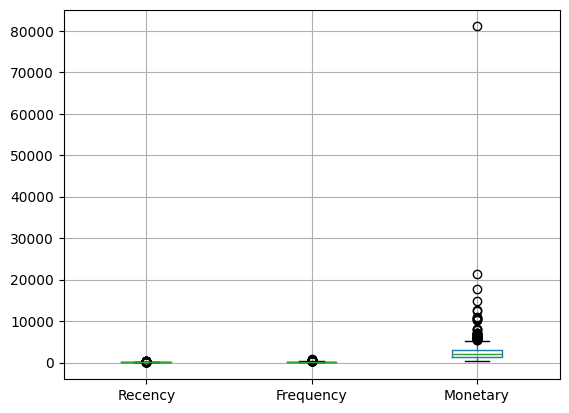

In [38]:
cluster_id = 1
customers_in_cluster = rfm[rfm['kmeans_cluster'] == cluster_id]
customers_in_cluster[['Recency','Frequency','Monetary']].boxplot()

## End-to-End Application Evaluations:
- Simulating the expected value of a recommendation strategy can be evaluated, according to `anticipated reponse rates (e.g. 1%, 5%, 10%, etc)`, and `proportion of cluster users affected (e.g. 1%, 5%, etc.)`.
- Once a strategy is selected, and activated for a cluster group of customers; evaluation data can be collected on its impact.
- Domain-objective impact for the target group might include:
  - `number of products sold (+)`
  - `customers lost (-)`
  - `average recency effect (+/-)`
  - `average frequency effect (+/-)`
  - `average monetary effect (+/-)`
- After a trial period is concluded, the strategy's implementation can be `evaluated`.
- According to the results, and sensitivity of the group it may be repeated or adjusted.